In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from PIL import Image
from PIL import ImageDraw
import math
plt.style.use({'figure.figsize':(10, 10)})

In [2]:
Epsilon_start=1
Epsilon_final=0.01
Robot_radium=40
Decay_rate=0.000001#he dacaying rate of the Epsilon, the range of the epsilon is 0.01-1, initially it is 1.
Action_times=0 #Rigister the totality of the times of selecting actions, including the random selections and selection based on Q_Table
Velocity_tripod=0.289*Robot_radium
Beta=0.9
Alpha=0.2

In [3]:
Q_table2_states=np.array(['L60D0/30','L180D0/30','L250D0/30','L300D0/30',
                'L60D30/60','L180D30/60','L250D30/60','L300D30/60',
                 'L60D60/90','L180D60/90','L250D60/90','L300D60/90',
                'L60D90/120','L180D90/120','L250D90/120','L300D90/120',
                'L60D120/150','L180D120/150','L250D120/150','L300D120/150',
                'L60D150/180','L180D150/180','L250D150/180','L300D150/180',
                'L60D180/210','L180D180/210','L250D180/210','L300D180/210',
                'L60D210/240','L180D210/240','L250D210/240','L300D210/240',
                'L60D240/270','L180D240/270','L250D240/270','L300D240/270',
                'L60D270/300','L180D270/300','L250D270/300','L300D270/300',
                'L60D300/330','L180D300/330','L250D300/330','L300D300/330',
                 'L60D330/360','L180D330/360','L250D330/360','L300D330/360'])
Q_table2_action=np.array(['Up','Left_45D','Right_45D'])
Q_table2_actions_length=len(Q_table2_action)
Q_table2_states_length=len(Q_table2_states)
Q_table2_real=np.zeros((Q_table2_states_length,Q_table2_actions_length))
Q_table2_real=pd.DataFrame(Q_table2_real,columns=Q_table2_action,index=Q_table2_states)
Q_table2_real.head()

,Up,Left_45D,Right_45D
L60D0/30,0.0,0.0,0.0
L180D0/30,0.0,0.0,0.0
L250D0/30,0.0,0.0,0.0
L300D0/30,0.0,0.0,0.0
L60D30/60,0.0,0.0,0.0


In [4]:
def Set_destination(x,y):
    return x,y
# Destination_x,Destination_y=Set_destination(900,900)

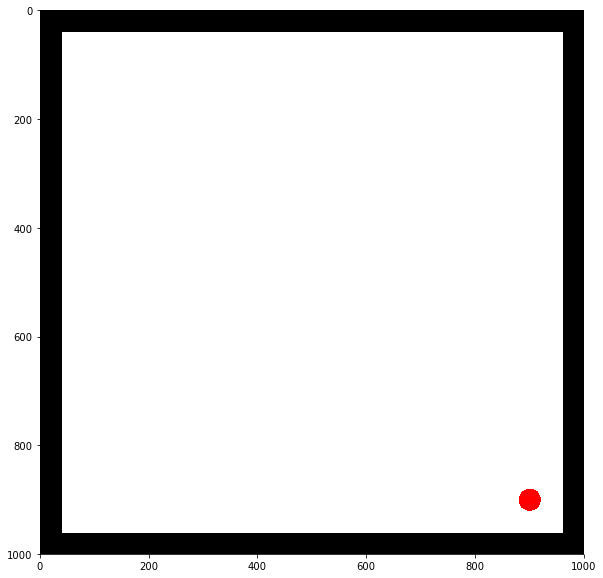

In [5]:
#Draw_map2 funcion is used to train the first Q-Table2, which allows it to arrive to the destination
def Draw_map(Destination_x,Destination_y):
    im = Image.new("RGB", size=(1000,1000),color=(0,0,0)) 
    draw = ImageDraw.Draw(im,mode='RGB')
    draw.rectangle((40,40,960,960),(255,255,255),(255,255,255))
    draw.ellipse((Destination_x-20,Destination_y-20,Destination_x+20,Destination_y+20), (255,0,0), (255,0,0)) 
    return im
# im=Draw_map(900,900)
# plt.imshow(im)
# plt.show()

In [6]:
def Initial_Q_Table2(LengthOfActions,LengthOfStates):
    Q_table2=np.zeros((LengthOfStates,LengthOfActions))
    print('***********************************************************')
    print("Succeed to initialize Q-table2!")
    print('***********************************************************')
    return Q_table2

In [7]:
def Robot_destination(Destination_x,Destination_y,Current_x,Current_y,Current_angle):
    #Left-negative,180-360 |||| Right-positive,0-180
    Delta_x=Destination_x-Current_x
    Delta_y=Destination_y-Current_y
    Distance=np.sqrt(Delta_x*Delta_x+Delta_y*Delta_y)
    Direct_angle=(np.arctan(Delta_y/Delta_x))*180/np.pi
    if Delta_x<0:
        Direct_angle=Direct_angle+180
    True_angle=(Current_angle-Direct_angle)%360
#     print(true_angle)
    if True_angle>180:
        return 360-True_angle,'right',Distance
    else:
        return True_angle,'left',Distance

In [8]:
#Is_Crash function, in the second map, is used to judge if the robot collides with the black frame
def Is_Crash(Current_x,Current_y,im):
    Crash=False
    Degree=[-150,-120,-90,-60,-30,0,30,60,90,120,150,180]
    Dis=np.arange(0,50,5)
    for i in Dis:
        for j in Degree:
            x=Current_x+i*np.cos(j/180*np.pi)
            y=Current_y+i*np.sin(j/180*np.pi)
            if (im.getpixel((x,y)))==(0,0,0):
                Crash=True
                break
        if Crash==True:
                break
    return Crash

In [9]:
def Is_arrive(Current_x,Current_y,im):
    Arrive=False
    Crash=False
    Degree=[-150,-120,-90,-60,-30,0,30,60,90,120,150,180]
    Distance=np.arange(0,20,5)
    for i in Distance:
        for j in Degree:
            x=Current_x+i*np.cos(j/180*np.pi)
            y=Current_y+i*np.sin(j/180*np.pi)
            if (im.getpixel((x,y)))==(0,0,0):
                Crash=True
                break
            if (im.getpixel((x,y)))==(255,0,0):
                Arrive=True
                break
        if Arrive==True or Crash==True:
                break
    return Arrive
# print(Is_arrive(500,500))

In [10]:
#Random_start function, in the second map, is used to set the beginning point in the white map.
def Random_start(im):
    Angle=0
    x,y=np.random.random(2)*1000
    while(Is_Crash(x,y,im)==True or Is_arrive(x,y,im)==True):
#         print('Boom')
        x,y=np.random.random(2)*1000
    return x,y,Angle

In [11]:
def Output_state_index(True_angle,Left_right,Distance):
    if 0<=Distance<60:
        Distance_level=0
    elif 60<=Distance<180:
        Distance_level=1
    elif 180<=Distance<250:
        Distance_level=2
    else:
        Distance_level=3
    Angle_level=True_angle//30
    
    if Left_right=='right':
        Left_right_level=1
        State_number=int(Distance_level+24*Left_right_level+(5-Angle_level)*4)
    elif Left_right=='left':
        Left_right_level=0
        Angle_level=True_angle//30
        State_number=int(Distance_level+24*Left_right_level+Angle_level*4)
    return State_number,Distance_level,Angle_level
# State_Number,_,_=Output_state_index(20,'right',299) #180 belongs to 180-210,''right' does not have 180
# Q_table2_states[State_Number]
    
    
    

In [12]:
def Choose_action2(Q_Table,Current_state,Action_times):
    Epsilon=Epsilon_final+(Epsilon_start-Epsilon_final)*np.exp(-1*Decay_rate*Action_times)
    State_action=Q_Table[Current_state,:]
    if(np.random.random()<Epsilon or np.all(State_action==[0])):
        Next_action=np.random.randint(Q_table2_actions_length)
    else:
        Next_action=np.argmax(State_action)
    return Next_action
# print(Choose_action2(Q_Table2,20,0))

In [13]:
def Output_next_state(Current_x,Current_y,Current_angle,Destination_x,Destination_y,Action,im):
    Arrive=False
    Crash=False
    if Action==0:
        Next_x=Current_x+Velocity_tripod*np.cos(Current_angle/180*np.pi)
        Next_y=Current_y+Velocity_tripod*np.sin(Current_angle/180*np.pi)
        Next_angle=Current_angle
        if Is_Crash(Next_x,Next_y,im)==True:
            Crash=True
        if Is_arrive(Next_x,Next_y,im)==True:
            Arrive=True
    elif Action==1:
        Next_x=Current_x
        Next_y=Current_y
        Next_angle=Current_angle-45
    elif Action==2:
        Next_x=Current_x
        Next_y=Current_y
        Next_angle=Current_angle+45        
    True_angle,Left_right,Distance=Robot_destination(Destination_x,Destination_y,Next_x,Next_y,Next_angle)
    State_number,Distance_level,Angle_level=Output_state_index(True_angle,Left_right,Distance)
    if Arrive==False:
        Reward=Distance_level*-0.5-Angle_level
    elif Arrive==True:
        Reward=50
    return Next_x,Next_y,Next_angle,Reward,State_number,Arrive,Crash
#Next_state_F2(600,600,50,1800,1800,1)

In [14]:
def Movement_plot(Vec_x,Vec_y,Destination_x,Destination_y):
    im=Image.new("RGB", size=(1000,1000),color=(0,0,0))
    draw=ImageDraw.Draw(im,mode='RGB')
    draw.rectangle((40,40,960,960),255,255)
    draw.ellipse((Destination_x-20,Destination_y-20,Destination_x+20,Destination_y+20),(255,0,0),(255,0,0))
    for i,j in zip(Vec_x,Vec_y):
        draw.ellipse((i-40,j-40, i+40,j+40),150,150) 
    return im

# plt.imshow(im)
# plt.show()


In [15]:
Q_Table2=Initial_Q_Table2(Q_table2_actions_length,Q_table2_states_length)
global Epoche
Epoche=0
global Action_times #Rigister the totality of the times of selecting actions, including the random selections and selection based on Q_Table
Action_times=0
global Epoche_action_interval

***********************************************************
Succeed to initialize Q-table2!
***********************************************************


In [16]:
Q_table2=np.loadtxt(r"E:\Graduate\python\Q_Table_notgait_finish\Q_Table2_notgait\Q_Table2_notgait_2.txt")

72


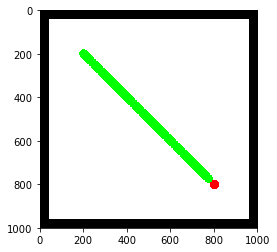

In [17]:
%matplotlib qt5
def Draw_result(Destination_x,Destination_y,Start_x,Start_y,Start_angle,Q_table):
    Path_x=[]
    Path_y=[]
    Current_x=Start_x
    Current_y=Start_y
    Current_angle=Start_angle
    Arrive=False
    im=Draw_map(Destination_x,Destination_y)
    while Arrive==False:
        Path_x.append(Current_x)
        Path_y.append(Current_y)
        True_angle,Left_right,Distance=Robot_destination(Destination_x,Destination_y,
                                                             Current_x,Current_y,Current_angle)
        Current_state_number,Distance_level,Angle_level=Output_state_index(True_angle,
                                                                               Left_right,Distance)
        State_action=Q_table2[Current_state_number,:]
        Next_action=np.argmax(State_action)
        Next_x,Next_y,Next_angle,Reward,Next_state_number,Arrive,Crash=Output_next_state(Current_x,Current_y,
                                                                    Current_angle,Destination_x,Destination_y,Next_action,im)
        Current_x=Next_x
        Current_y=Next_y
        Current_angle=Next_angle
    im_result=Image.new("RGB", size=(1000,1000),color=(0,0,0))
    draw_result=ImageDraw.Draw(im_result,mode='RGB')
    draw_result.rectangle((40,40,960,960),(255,255,255),(255,255,255))
    draw_result.ellipse((Destination_x-20,Destination_y-20,Destination_x+20,Destination_y+20),(255,0,0),(255,0,0))
    print(len(Path_x))
    for d in range(36):
        for i,j in zip(Path_x[2*d:2*d+2],Path_y[2*d:2*d+2]):
            draw_result.ellipse((i-20,j-20, i+20,j+20),(0,255,0),(0,255,0))
            plt.imshow(im_result)
            plt.savefig((r"E:\Graduate\python\Q_Table_notgait_finish\Q_Table2_notgait\Pic\picture")+str(d)+".png")
    return im_result
im_result=Draw_result(800,800,200,200,0,Q_Table2)
plt.imshow(im_result)
plt.show()

In [ ]:
# np.savetxt("Q_Table2_notgait2.txt",Q_Table2_final)